<a href="https://colab.research.google.com/github/sosanzma/Exoplantets_autoencoders/blob/main/exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # TRABAJO DETECCIÓN ANOMALIAS. 
 ### DEEP LEARNING
 #####   MANEL SOLER SANZ

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
%matplotlib inline
from sklearn import datasets
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.layers import Input, Dense , Conv2D, MaxPooling2D, UpSampling2D,Dropout
from keras.models import Model
#SciPy: scientific tools
import scipy.io.matlab as matlab
import librosa, librosa.display



# Data set : 

This repository contains the PHL-EC dataset used in the classification problem for exoplanets. The data set is used in the manuscript "Habitability Classification of Exoplanets: A Machine Learning Insight"

In [ ]:
url = "https://raw.githubusercontent.com/mathurarchana77/Habitability-PHL-EC-Dataset/main/PHL-EC.csv"
data = pd.read_csv(url) 
data.head()

,P. Name,P. Name Kepler,P. Name KOI,P. Zone Class,P. Mass Class,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Min Mass (EU),P. Mass (EU),...,P. Int ESI,P. Surf ESI,P. ESI,S. HabCat,P. Habitable,P. Hab Moon,P. Confirmed,P. Disc. Method,P. Disc. Year,Unnamed: 68
0,1RXS 1609 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,4451.16,...,0,0,0.05,0,0,0,1,Imaging,2008,NaN
1,1SWASP J1407 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,6358.80,...,0,0,0.07,0,0,0,1,Primary Transit,2012,NaN
2,2M 0103-55(AB) b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,4133.22,4133.22,...,0,0,0.06,0,0,0,1,Imaging,2013,NaN
3,2M 0122-24 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,6358.80,...,0,0,0.08,0,0,0,1,Imaging,2013,NaN
4,2M 0219-39 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,4419.37,...,0,0,0.06,0,0,0,1,Imaging,2015,NaN


In [ ]:
data.shape


(3875, 69)

## Pre-procesado de los datos

No podemos utilizar el data set en nuestros autoendocers sin antes preprocesar los datos y adecuarlos para nuestro objetivo: *Detectar planetas habitables como anomalias.*

Primeramente vamos a analizar los datos no númericos:

In [ ]:
for y in data.columns:
    if (is_string_dtype(data[y])):
        #num_data.drop(y, axis=1, inplace=True)
        print(y)
    #elif (is_numeric_dtype(num_data[y])):
        #print(y,"numeric")


P. Name
P. Name Kepler
P. Zone Class
P. Mass Class
P. Composition Class
P. Atmosphere Class
P. Habitable Class
P. SFlux Min (EU)
P. SFlux Mean (EU)
P. SFlux Max (EU)
S. Name
S. Name HD
S. Name HIP
S. Constellation
S. Type
P. Disc. Method
P. Disc. Year


In [ ]:
data["P. Zone Class"]

0       Cold
1       Cold
2       Cold
3       Cold
4       Cold
        ... 
3870     Hot
3871     Hot
3872     Hot
3873     Hot
3874     Hot
Name: P. Zone Class, Length: 3875, dtype: object

Las variables de flujo deberian ser númericas : 

In [ ]:
data["P. SFlux Min (EU)"] = pd.to_numeric(data["P. SFlux Min (EU)"],errors='coerce')
data["P. SFlux Mean (EU)"] = pd.to_numeric(data["P. SFlux Mean (EU)"],errors='coerce')
data["P. SFlux Max (EU)"] = pd.to_numeric(data["P. SFlux Max (EU)"],errors='coerce')

Vamos a codificar algunad variables que son categóricas como númericas, porque creemos que es informcación útil para abordar el problema. Para ello utilizaremos la funcion se sklearn : `OrdinalEncoder`

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
data["P. Atmosphere Class_code"] = ord_enc.fit_transform(data[["P. Atmosphere Class"]])
ord_enc = OrdinalEncoder()
data["P. Mass Class_code"] = ord_enc.fit_transform(data[["P. Mass Class"]])
ord_enc = OrdinalEncoder()
data["P. Composition Class_code"] = ord_enc.fit_transform(data[["P. Composition Class"]])

ord_enc = OrdinalEncoder()
data["P. Zone Class_code"] = ord_enc.fit_transform(data[["P. Zone Class"]])



Nos quedamos con los númericos

---
Una vez hemos codificado los categóricos elegidos  como númericos, vamos a eliminar todos los categóricos, ya que estos no vamos a poder utilizarlos en nuestro autoencoder


---





In [ ]:
num_data = data.copy()

for y in num_data.columns:
    if (is_string_dtype(num_data[y])):
        num_data.drop(y, axis=1, inplace=True)

    elif (is_numeric_dtype(num_data[y])):
        print(y,"numeric")

P. Name KOI numeric
P. Min Mass (EU) numeric
P. Mass (EU) numeric
P. Max Mass (EU) numeric
P. Radius (EU) numeric
P. Density (EU) numeric
P. Gravity (EU) numeric
P. Esc Vel (EU) numeric
P. SFlux Min (EU) numeric
P. SFlux Mean (EU) numeric
P. SFlux Max (EU) numeric
P. Teq Min (K) numeric
P. Teq Mean (K) numeric
P. Teq Max (K) numeric
P. Ts Min (K) numeric
P. Ts Mean (K) numeric
P. Ts Max (K) numeric
P. Surf Press (EU) numeric
P. Mag numeric
P. Appar Size (deg) numeric
P. Period (days) numeric
P. Sem Major Axis (AU) numeric
P. Eccentricity numeric
P. Mean Distance (AU) numeric
P. Inclination (deg) numeric
P. Omega (deg) numeric
S. Mass (SU) numeric
S. Radius (SU) numeric
S. Teff (K) numeric
S. Luminosity (SU) numeric
S. [Fe/H] numeric
S. Age (Gyrs) numeric
S. Appar Mag numeric
S. Distance (pc) numeric
S. RA (hrs) numeric
S. DEC (deg) numeric
S. Mag from Planet numeric
S. Size from Planet (deg) numeric
S. No. Planets numeric
S. No. Planets HZ numeric
S. Hab Zone Min (AU) numeric
S. Hab Zo

In [ ]:
print("Nans en total", data.isnull().sum().sum()) # Nans en total


print( "Numero e planetas habitables", np.sum(num_data["P. Habitable"][num_data["P. Habitable"]==1]))
print( "Numero de planetas NO habitables",(np.sum(num_data["P. Habitable"]==0)))

num_data.shape

Nans en total 40930
Numero e planetas habitables 55
Numero de planetas NO habitables 3820


(3875, 59)

In [ ]:
df =num_data.copy()

## borramos esta columna porque no nos sirve
df.drop("Unnamed: 68", axis=1, inplace=True)

Tenemos columnas donde tenemos todo zeros o NaNs:



> Estas columnas las eliminaremos


In [ ]:
print(df[~df['P. Max Mass (EU)'].isnull()])

print(np.sum(df['P. Int ESI']))

print(np.sum(df['P. Surf ESI']))

Empty DataFrame
Columns: [P. Name KOI, P. Min Mass (EU), P. Mass (EU), P. Max Mass (EU), P. Radius (EU), P. Density (EU), P. Gravity (EU), P. Esc Vel (EU), P. SFlux Min (EU), P. SFlux Mean (EU), P. SFlux Max (EU), P. Teq Min (K), P. Teq Mean (K), P. Teq Max (K), P. Ts Min (K), P. Ts Mean (K), P. Ts Max (K), P. Surf Press (EU), P. Mag, P. Appar Size (deg), P. Period (days), P. Sem Major Axis (AU), P. Eccentricity, P. Mean Distance (AU), P. Inclination (deg), P. Omega (deg), S. Mass (SU), S. Radius (SU), S. Teff (K), S. Luminosity (SU), S. [Fe/H], S. Age (Gyrs), S. Appar Mag, S. Distance (pc), S. RA (hrs), S. DEC (deg), S. Mag from Planet, S. Size from Planet (deg), S. No. Planets, S. No. Planets HZ, S. Hab Zone Min (AU), S. Hab Zone Max (AU), P. HZD, P. HZC, P. HZA, P. HZI, P. SPH, P. Int ESI, P. Surf ESI, P. ESI, S. HabCat, P. Habitable, P. Hab Moon, P. Confirmed, P. Atmosphere Class_code, P. Mass Class_code, P. Composition Class_code, P. Zone Class_code]
Index: []

[0 rows x 58 column

In [ ]:
# lo borramos


for y in df.columns:
  if(np.mean(df[y]) == 0 or np.isnan(np.mean(df[y])) == True):
    df.drop(y, axis=1, inplace=True)

df.shape

(3875, 55)

Borramos todas las columnas que tengans más de 800 NaNs:

In [ ]:

print("columnas sin NaN: ",48-np.sum(df.isnull().any()))

df.isnull().any()
df2 = df.copy()

for y in df.columns:
  if(np.sum(df[y].isnull()) > 800 ):  # tengamos menos de 800 NaNs
    df2.drop(y, axis=1, inplace=True)
print("Nuestro data set actual tiene las siguientes dimesiones:", df2.shape)

columnas sin NaN:  3
Nuestro data set actual tiene las siguientes dimesiones: (3875, 44)


Borramos los datos de plantetas que contengan NaN:

In [ ]:
df2 = df2.dropna(axis = 0)
df2.shape
df2.isnull().any()


P. Mass (EU)                 False
P. Radius (EU)               False
P. Density (EU)              False
P. Gravity (EU)              False
P. Esc Vel (EU)              False
P. SFlux Min (EU)            False
P. SFlux Mean (EU)           False
P. SFlux Max (EU)            False
P. Teq Min (K)               False
P. Teq Mean (K)              False
P. Teq Max (K)               False
P. Surf Press (EU)           False
P. Mag                       False
P. Appar Size (deg)          False
P. Period (days)             False
P. Sem Major Axis (AU)       False
P. Eccentricity              False
P. Mean Distance (AU)        False
P. Omega (deg)               False
S. Mass (SU)                 False
S. Radius (SU)               False
S. Teff (K)                  False
S. Luminosity (SU)           False
S. RA (hrs)                  False
S. DEC (deg)                 False
S. Mag from Planet           False
S. Size from Planet (deg)    False
S. No. Planets               False
S. No. Planets HZ   

Ya tenemos nuestro data set sin valores perdidos. Ahora ya podemos pasar a constuir nuestros detectores de anomalias

---



---

## Autoencoders

---

Preparamos los datos:

In [ ]:
 # Esta serà nuestra varibles respuesta : 

 df2["P. Habitable"]

1       0
6       0
9       0
10      0
17      0
       ..
3870    0
3871    0
3872    0
3873    0
3874    0
Name: P. Habitable, Length: 3632, dtype: int64

Dividimos el data set en variables input y las etiquetas . 

y = 0 : No habitable

y = 1 : Habitable

In [ ]:
X = df2.loc[:, df2.columns != "P. Habitable"]  
y = df2["P. Habitable"]  
print(np.shape(y),np.shape(X))

(3632,) (3632, 43)


In [ ]:
# 1 = outliers, 0 = inliers

print("Numero de outliers : ",np.sum(y== 1))
print("Numero de inliers : ",np.sum(y== 0))

Numero de outliers :  55
Numero de inliers :  3577


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split( 
   # Xf, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.3, random_state=42)



#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Dividimos los sets de entrenamiento y test en Normal Data y Fraud Data:

In [ ]:
train_labels = y_train.astype(bool)
test_labels = y_test.astype(bool)#creating normal and fraud datasets
normal_train_data = X_train[~train_labels]
normal_test_data = X_test[~test_labels]
fraud_train_data = X_train[train_labels]
fraud_test_data = X_test[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Fraud Train Data= 34
 No. of records in Normal Train data= 2508
 No. of records in Fraud Test Data= 21
 No. of records in Normal Test data= 1069


In [ ]:
# No tenemos valores negativos € (0,1) !

print(np.min(normal_train_data),np.max(normal_train_data))

#normal_train_data[np.isnan(normal_train_data)]

0.0 1.0000000000000002


Ahora que ya tenemos los datos preparados, solo queda construir las diferente arquitecturas que vamos a utilizar para detectar los datos anómalos . 

Vamos a utilizar :

*   AUTO_DEP_AD 
*   PCA + AUTOAD
*   AUTODR + AUTOAD







# AUTO_DEP_AD

### Autoencoder profundo + detecetor de anomalias. 

Construimos un autoencoder que tomará todos los datos y lo entrenaremos con los datos no anómalos. De este modo, esperamos que cuando le entre un dato anómalo, el error de reconstrucción va a ser mayor a los normales, de este modo vamos a poder establecer un threshold para el error de reconstrucción. 


---
## Elección del threshold: 

En los tres métodos que vamos a usar el threshold es el mismo . Hemos elegido la media de el error de reconstrucción de los *datos anomalos* del conjunto test y a este error le hemos restado su desviación estandar. El porqué de la resta y no la suma es por heurística. Es lo que mejor se ha ajustado. 

Es verdad que en un problema real no tenemos el valor del conjunto test, porque no conozemos. En este caso se hubiera hecho con el de entrenamiento.



---



### Elección de la estructura del autoencoder :

Como partiamos de una data set de 43 dimensiones, la primera capa queríamos que tuviera un mayoe número de capas, pero sin excederse. Por eso hemos elegido 64, a partir de ahí hemos ido disminuyendo a la dimensión a la mitad.  Finalmente hemos elegido una dimensión de codifciación de 10 porque en las diferentes pruebas que hemos hecho, es la que mejor resultado nos ha dado. La última capa pensamos en  función de activación `sigmoid` ya que buscamos replicar los datos que previamente han sido pasados por el `MinMaScaler` y por tanto estan entre (0,1). En cambió, probamos con `tanh` y los resultados mejoraron, por lo que dejamos está última .




In [ ]:
#Aquitectura:

dimension_entrada = 43
dimension_codificacion = 10



entrada = Input(shape=(dimension_entrada,))
encoded = Dense(64, activation='relu')(entrada)

encoded = Dense(32, activation='relu')(encoded)
encoded = Dropout(0.1)(encoded)
encoded = Dense(16, activation='relu')(encoded)

encoded = Dense(dimension_codificacion, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(decoded)
decoded= Dropout(0.1)(decoded)
decoded = Dense(64, activation='relu')(decoded)

decodificada = Dense(dimension_entrada, activation='tanh')(decoded)

autoencoder = Model(entrada,decodificada) 
autoencoder.compile(optimizer=  'adam' ,loss = 'mse')


history2 = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=50,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(normal_test_data,normal_test_data))

Epoch 1/50
79/79 [==============================] - 7s 16ms/step - loss: 0.0437 - val_loss: 0.0192
Epoch 2/50
79/79 [==============================] - 1s 10ms/step - loss: 0.0164 - val_loss: 0.0124
Epoch 3/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 4/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 5/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 6/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 7/50
79/79 [==============================] - 1s 10ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 8/50
79/79 [==============================] - 1s 10ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 9/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 10/50
79/79 [==============================] - 1s 10ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 11/

In [ ]:
## Le pasamos los datos de test al autoencoder ya entrenado

test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.abs(X_test-test_x_predictions)**2
                    , axis = tuple(range(1,X_test.ndim)))

# alamacenamos el error de cada uno junto con su etiqueta
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

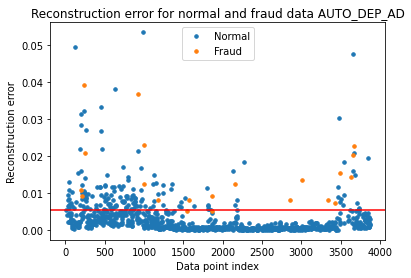

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
#ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
threshold =  np.mean( error_df[error_df["True_class"]==True]["Reconstruction_error"])-np.std( error_df[error_df["True_class"]==True]["Reconstruction_error"])
plt.axhline(y= threshold, color='r', linestyle='-')
plt.title("Reconstruction error for normal and fraud data AUTO_DEP_AD")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
print(np.mean(error_df[error_df["True_class"]==False]))
print(np.mean(error_df[error_df["True_class"]==True]))

teoric_fraud = []
teoric_ok = []
pred_labels = []
for i in range(len(error_df)):
  if (error_df.iloc[i,0]>= threshold):
    teoric_fraud.append(error_df.iloc[i][["Reconstruction_error","True_class"]])
    pred_labels.append(1)
  else :
    teoric_ok.append(error_df.iloc[i][["Reconstruction_error","True_class"]])
    pred_labels.append(0)
print("threshold: ", threshold)

Reconstruction_error    0.00293
True_class              0.00000
dtype: float64
Reconstruction_error    0.014836
True_class              1.000000
dtype: float64
threshold:  0.005636706981138655


## Resultado

Vamos a describir los haciertos y erroes que hemos cometido:

Outliers:

In [ ]:
print("Numero de outliers en el data set original :",len(error_df[error_df["True_class"]==True]))
print("Numero de outliers etiquetados como tal :" , np.sum([i[1]== True for i in teoric_fraud]))

print("Accuracy: ",np.sum([i[1]== True for i in teoric_fraud])/len(error_df[error_df["True_class"]==True]))

Numero de outliers en el data set original : 21
Numero de outliers etiquetados como tal : 19
Accuracy:  0.9047619047619048


Inliers:

In [ ]:
print("Numero de inliers en el data set probado :", len(error_df[error_df["True_class"]==False])) 
print("Numero de intliers etiquetados como tal :",np.sum([i[1]== False for i in teoric_ok]))

print("Accuracy: ", np.sum([i[1]== False for i in teoric_ok])/len(error_df[error_df["True_class"]==False]))

Numero de inliers en el data set probado : 1069
Numero de intliers etiquetados como tal : 913
Accuracy:  0.8540692235734331


Errores en el etiquetado

In [ ]:
print("Error en el etiquetado de inliers  :", np.sum([i[1]== True for i in teoric_ok])/len(error_df[error_df["True_class"]==True]),"%") 
print("Error en el etiquetado de outliers  :", np.sum([i[1]== False for i in teoric_fraud])/len(error_df[error_df["True_class"]==False]),"%") 

Error en el etiquetado de inliers  : 0.09523809523809523 %
Error en el etiquetado de outliers  : 0.14593077642656688 %


Otro método de medir el acierto

In [ ]:

print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))


[[913 156]
 [  2  19]]
              precision    recall  f1-score   support

       False       1.00      0.85      0.92      1069
        True       0.11      0.90      0.19        21

    accuracy                           0.86      1090
   macro avg       0.55      0.88      0.56      1090
weighted avg       0.98      0.86      0.91      1090



# Combinacion de dos autoencoders :

### Reduccion de dimensionalidad (**AutoRD**) + Detección de anomalias (**AutoAD**).

**AutoRD**: reducir la dimensionalidad minimizando el error de reconstrucción. Para entrenar, pasaremos todos tipo de datos, tanto anomalos como no anomalos, y lo entrenaremos para que sea capaz de reducirlos. Una vez  tenemos autRD entrenado, pasamos al **AutoAD**.

**AutoAD** :  Lo que le pasamos de entrada al autAD son datos reducidos, es decir, pasados previamente por codificador de autRD. Como queremos que funcione para detección de anomalías, solo le pasaremos datos reducidos pero que estuvieran etiquetados como no anómalos. Y entrenar con esos datos para minimizar el error de reconstrucción.  





### AUTORD
---

### Elección de la estructura del autoencoder :

En el caso del AutoRD, utilizamos una función de activación `tanh` porque nos dimos cuenta que ofrecía un error de reconstrucción menor y en este primer autoencoder lo único que nos importa es conseguir reducir la dimensionalidad y que la máxima información siga presenta. También porque es lo que mejor resultado nos ha ofrecido

In [ ]:

dimension_entrada = 43
dimension_codificacion = 20



entrada = Input(shape=(dimension_entrada,))
encoded = Dense(64, activation='relu')(entrada)

encoded = Dense(32, activation='relu')(encoded)
#encoded = Dropout(0.1)(encoded)


encoded = Dense(dimension_codificacion, activation='relu')(encoded)


decoded = Dense(32, activation='relu')(encoded)
#decoded= Dropout(0.1)(decoded)
decoded = Dense(64, activation='relu')(decoded)

decodificada = Dense(dimension_entrada, activation='tanh')(decoded)

autoencoder = Model(entrada,decodificada) 
autoencoder.compile(optimizer=  'adam' ,loss = 'mse')


history2 = autoencoder.fit(X_train, X_train,
                    epochs=50,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test,X_test))

Epoch 1/50
80/80 [==============================] - 1s 7ms/step - loss: 0.0377 - val_loss: 0.0154
Epoch 2/50
80/80 [==============================] - 0s 5ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 3/50
80/80 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 4/50
80/80 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 5/50
80/80 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 6/50
80/80 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 7/50
80/80 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 8/50
80/80 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 9/50
80/80 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/50
80/80 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 11/50
80/80 [

In [ ]:
autoencoder.layers[-3]

In [ ]:

codificador = Model(entrada, encoded)
entrada_codificada = Input(shape=(dimension_codificacion, ))
decoder_layer_1 = autoencoder.layers[-3](entrada_codificada)
decoder_layer_2 = autoencoder.layers[-2](decoder_layer_1)

decoder_output = autoencoder.layers[-1](decoder_layer_2)
decodificador = Model(entrada_codificada,decoder_output)

Le pasaremos a el codificador, todos los datons no-anómalos, una vez codificados, usaremos esto para entrenear a el autoencoder que se encaragara de drtectar anómalias

In [ ]:
inliers_codificados = codificador.predict(normal_train_data)
inliers_codificados.shape

(2508, 20)

### AUTOAD

### Elección de la estructura del autoencoder :

En el caso del AutoRD, utilizamos una función de activación `tanh` porque nos dimos cuenta que ofrecía un error de reconstrucción menor. Decidimos que el espacio letente de la codficiación fuera de 4 dimensiones por no comprimir mucho más la información.



In [ ]:
dimension_entrada = inliers_codificados.shape[1]
dimension_codificacion = 4





entrada = Input(shape=(dimension_entrada,))



#encoded = Dropout(0.1)(encoded)
encoded = Dense(32, activation='relu')(entrada)

encoded = Dense(8, activation='relu')(encoded)

encoded = Dense(dimension_codificacion, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)


#decoded= Dropout(0.1)(decoded)

decodificada = Dense(dimension_entrada, activation='tanh')(decoded)
autoencoder_AD = Model(entrada,decodificada) 
autoencoder_AD.compile(optimizer=  'adam' ,loss = 'mse')


history2 = autoencoder_AD.fit(inliers_codificados, inliers_codificados,
                    epochs=50,
                    batch_size=32,
                    shuffle=True)

Epoch 1/50
79/79 [==============================] - 2s 6ms/step - loss: 0.4951
Epoch 2/50
79/79 [==============================] - 1s 6ms/step - loss: 0.1466
Epoch 3/50
79/79 [==============================] - 1s 7ms/step - loss: 0.1318
Epoch 4/50
79/79 [==============================] - 1s 7ms/step - loss: 0.1276
Epoch 5/50
79/79 [==============================] - 1s 7ms/step - loss: 0.1254
Epoch 6/50
79/79 [==============================] - 1s 7ms/step - loss: 0.1244
Epoch 7/50
79/79 [==============================] - 1s 8ms/step - loss: 0.1235
Epoch 8/50
79/79 [==============================] - 1s 6ms/step - loss: 0.1227
Epoch 9/50
79/79 [==============================] - 0s 6ms/step - loss: 0.1217
Epoch 10/50
79/79 [==============================] - 0s 6ms/step - loss: 0.1202
Epoch 11/50
79/79 [==============================] - 0s 5ms/step - loss: 0.1190
Epoch 12/50
79/79 [==============================] - 1s 7ms/step - loss: 0.1184
Epoch 13/50
79/79 [==============================

In [ ]:
test_codificado = codificador.predict(X_test)
ADtest_x_predictions = autoencoder_AD.predict(test_codificado)
mse = np.mean(np.abs(test_codificado-ADtest_x_predictions)**2
                    , axis = tuple(range(1,X_test.ndim)))

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

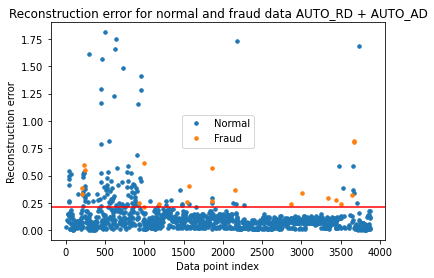

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
#ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
threshold =  np.mean( error_df[error_df["True_class"]==True]["Reconstruction_error"])-np.std( error_df[error_df["True_class"]==True]["Reconstruction_error"])
plt.axhline(y= threshold, color='r', linestyle='-')
plt.title("Reconstruction error for normal and fraud data AUTO_RD + AUTO_AD")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
print(np.mean(error_df[error_df["True_class"]==False]))
print(np.mean(error_df[error_df["True_class"]==True]))

teoric_fraud = []
teoric_ok = []
pred_labels = []
for i in range(len(error_df)):
  if (error_df.iloc[i,0]>= threshold):
    teoric_fraud.append(error_df.iloc[i][["Reconstruction_error","True_class"]])
    pred_labels.append(1)
  else :
    teoric_ok.append(error_df.iloc[i][["Reconstruction_error","True_class"]])
    pred_labels.append(0)
print("threshold: ", threshold)

Reconstruction_error    0.122948
True_class              0.000000
dtype: float64
Reconstruction_error    0.398924
True_class              1.000000
dtype: float64
threshold:  0.21679583191871643


No comento los resultados con más detalle porque no es la estructura que mejor resultados nos ha dado. Dejamos las siguientes metricas:

In [ ]:

print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

[[953 116]
 [  1  20]]
              precision    recall  f1-score   support

       False       1.00      0.89      0.94      1069
        True       0.15      0.95      0.25        21

    accuracy                           0.89      1090
   macro avg       0.57      0.92      0.60      1090
weighted avg       0.98      0.89      0.93      1090



## PCA + Autencoder

En este último apartado, vamos a reducir la dimensionalidad del data set utilizando PCA, y una vemos hayamos reducido , pasaremos estos datos transformsdos por un autoencoder para intentar detectar los datos anómalos.


---

A partir de la varianza explicada de la PCA, hemos deidido que el númro de componentes a transformar será 10. A partir de 10 cada dimensión extra aporta poca información

---



Text(0.5, 0, 'Número de dimensiones')

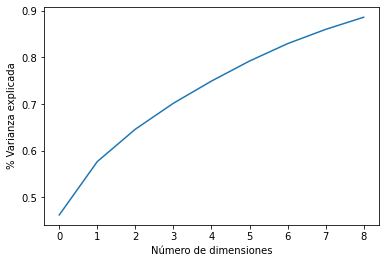

In [ ]:
pca = PCA(n_components = 9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel(" % Varianza explicada")
plt.xlabel("Número de dimensiones")

Text(0.5, 1.0, 'Distribucion de las dos primeras dimensiones en el espacio transformado')

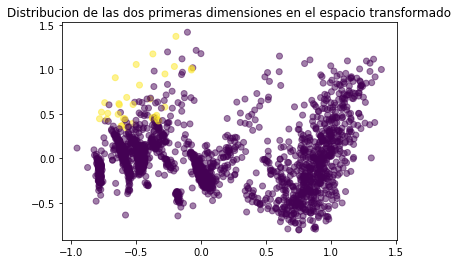

In [ ]:

plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c= train_labels, alpha = 0.5)
plt.title("Distribucion de las dos primeras dimensiones en el espacio transformado")

Vems que los datos anómalos se separan un poco de los normales

In [ ]:
train_labels = y_train.astype(bool)
test_labels = y_test.astype(bool)#creating normal and fraud datasets
normal_train_data = X_train_pca[~train_labels]
normal_test_data = X_test_pca[~test_labels]
fraud_train_data = X_train_pca[train_labels]
fraud_test_data = X_test_pca[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Fraud Train Data= 34
 No. of records in Normal Train data= 2508
 No. of records in Fraud Test Data= 21
 No. of records in Normal Test data= 1069


In [ ]:
# Aqui si que tenemos valores negativos del data set.
np.min(normal_train_data)

-0.9563063711618486


### Estructura del autoencoder: 

Otra vez hemos repetido el modelo anterior, ya que la codificación a 4 dimensiones y la función  de activación final 'tanh' son las que mejor resultado nos daban. Aquí la función de activación tiene más sentido porque si que tenemos valores negativos



---


Procedemos a montar el autoencoder

In [ ]:
dimension_entrada = 9
dimension_codificacion = 4



entrada = Input(shape=(dimension_entrada,))
encoded = Dense(36, activation='relu')(entrada)
#encoded = Dropout(0.03)(encoded)

encoded = Dense(16, activation='relu')(encoded)
#encoded = Dropout(0.03)(encoded)
encoded = Dense(8, activation='relu')(encoded)

encoded = Dense(dimension_codificacion, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
#decoded = Dropout(0.03)(decoded)

decoded = Dense(16, activation='relu')(decoded)
#decoded= Dropout(0.05)(decoded)
decoded = Dense(36, activation='relu')(decoded)

decodificada = Dense(dimension_entrada, activation='tanh')(decoded)

autoencoder = Model(entrada,decodificada) 
autoencoder.compile(optimizer=  'adam' ,loss = 'mse')


history2 = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=50,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(normal_test_data,normal_test_data))

Epoch 1/50
79/79 [==============================] - 3s 17ms/step - loss: 0.0617 - val_loss: 0.0430
Epoch 2/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0332 - val_loss: 0.0330
Epoch 3/50
79/79 [==============================] - 1s 15ms/step - loss: 0.0257 - val_loss: 0.0256
Epoch 4/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0214 - val_loss: 0.0227
Epoch 5/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0193 - val_loss: 0.0211
Epoch 6/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0178 - val_loss: 0.0190
Epoch 7/50
79/79 [==============================] - 1s 14ms/step - loss: 0.0166 - val_loss: 0.0183
Epoch 8/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0158 - val_loss: 0.0175
Epoch 9/50
79/79 [==============================] - 1s 10ms/step - loss: 0.0153 - val_loss: 0.0172
Epoch 10/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0148 - val_loss: 0.0163
Epoch 11/

In [ ]:
#X_test = X_test.reshape(738,20,20,1)

test_x_predictions = autoencoder.predict(X_test_pca)
mse = np.mean(np.abs(X_test_pca-test_x_predictions)**2
                    , axis = tuple(range(1,X_test_pca.ndim)))

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

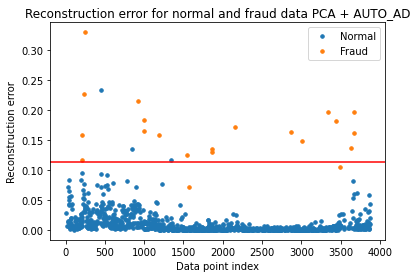

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
#ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
threshold =  np.mean( error_df[error_df["True_class"]==True]["Reconstruction_error"]) - np.std( error_df[error_df["True_class"]==True]["Reconstruction_error"])
plt.axhline(y= threshold, color='r', linestyle='-')
plt.title("Reconstruction error for normal and fraud data PCA + AUTO_AD" )
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
print(np.mean(error_df[error_df["True_class"]==False]))
print(np.mean(error_df[error_df["True_class"]==True]))

teoric_fraud = []
teoric_ok = []
pred_labels = []
for i in range(len(error_df)):
  if (error_df.iloc[i,0]>= threshold):
    teoric_fraud.append(error_df.iloc[i][["Reconstruction_error","True_class"]])
    pred_labels.append(1)
  else :
    teoric_ok.append(error_df.iloc[i][["Reconstruction_error","True_class"]])
    pred_labels.append(0)
print("threshold: ", threshold)

Reconstruction_error    0.009772
True_class              0.000000
dtype: float64
Reconstruction_error    0.165634
True_class              1.000000
dtype: float64
threshold:  0.11413548661640563


## Resultado

Vamos a describir los haciertos y erroes que hemos cometido:

Outliers:

In [ ]:
print("Numero de outliers en el data set original :",len(error_df[error_df["True_class"]==True]))
print("Numero de outliers etiquetados como tal :" , np.sum([i[1]== True for i in teoric_fraud]))

print("Accuracy: ",np.sum([i[1]== True for i in teoric_fraud])/len(error_df[error_df["True_class"]==True]))

Numero de outliers en el data set original : 21
Numero de outliers etiquetados como tal : 19
Accuracy:  0.9047619047619048


Inliers:

In [ ]:
print("Numero de inliers en el data set probado :", len(error_df[error_df["True_class"]==False])) 
print("Numero de intliers etiquetados como tal :",np.sum([i[1]== False for i in teoric_ok]))

print("Accuracy: ", np.sum([i[1]== False for i in teoric_ok])/len(error_df[error_df["True_class"]==False]))

Numero de inliers en el data set probado : 1069
Numero de intliers etiquetados como tal : 1066
Accuracy:  0.9971936389148737


Errores en el etiquetado

In [ ]:
print("Error en el etiquetado de inliers  :", np.sum([i[1]== True for i in teoric_ok])/len(error_df[error_df["True_class"]==True]),"%") 
print("Error en el etiquetado de outliers  :", np.sum([i[1]== False for i in teoric_fraud])/len(error_df[error_df["True_class"]==False]),"%") 

Error en el etiquetado de inliers  : 0.09523809523809523 %
Error en el etiquetado de outliers  : 0.002806361085126286 %


Otro método para medir el acierto:
Vemos que llegamos a un **99% de accuracy**

In [ ]:

print(confusion_matrix(test_labels,pred_labels))
print(classification_report(test_labels,pred_labels))

[[1066    3]
 [   2   19]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1069
        True       0.86      0.90      0.88        21

    accuracy                           1.00      1090
   macro avg       0.93      0.95      0.94      1090
weighted avg       1.00      1.00      1.00      1090



 # Resumen de Resultados :
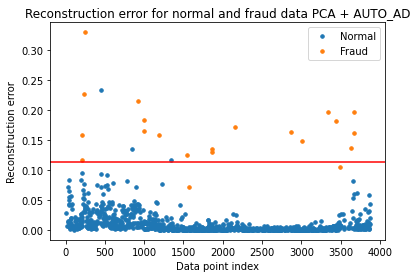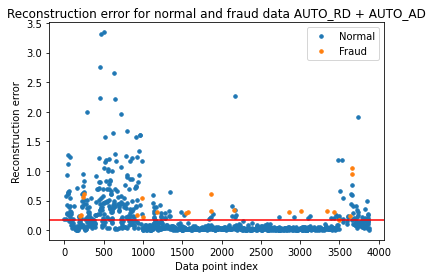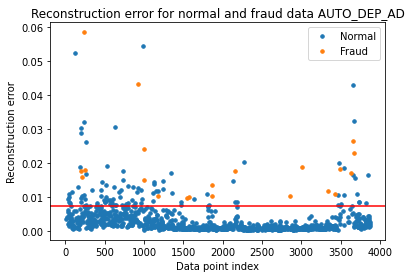

## Conclusión : 

Hemos realizado da detección de datos anómalos con tres estructuras diferentes : 

*   Autoencoder porfundo
*   Autoencoder reducion de dimensionalidad + Autoencoder detector anomalias
*   PCA y  Autoencoder detector anomalias


Donde mejores resultados hemos obtenido es en la PCA + Autoencoder. Esto puede deberse a que la reducción de la dimensionalidad mediante PCA ha conseguido encontrar las direcciones de máxima varianza de los datos  normales, separando aún mas los anómalos. 

Puede que nuestro autoencoder de reducción de la dimensionalidad, debido a su carácter altamente no lineal, no haya podido separar los dos tipos de datos, sino que ha encontrado direcciones no lineales lo que hacían era juntar más los datos. Esto último podemos verlo :

La primera estructura utilizada, el autoencoder profundo, ha dado unos resultados notables, pesee a partir de todo el data set entero. No obstante, vemos que una simpe reducción de dimension mediante PCA a mejorado significativamente los resultados.

Cabe también destacar la función final de activación `tanh` que ha mejorado las prestaciones, pese a no tener datos negativos en el data set en los dos primeros modelos.





Text(0.5, 1.0, 'Distribucion de las dos primeras dimensiones en el espacio transformado por el autoencoder')

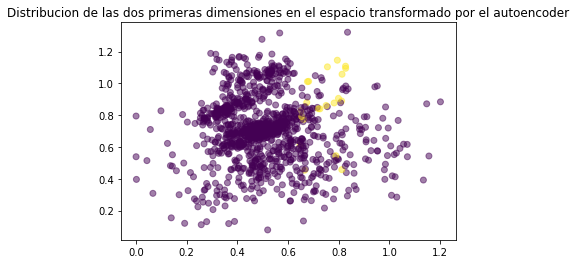

In [ ]:

plt.scatter(test_codificado[:,0], test_codificado[:,1], c= test_labels, alpha = 0.5)
plt.title("Distribucion de las dos primeras dimensiones en el espacio transformado por el autoencoder")

Vemos que pese a si estar separados los outliers del los conjuntos mas densos, hay muchos datos *normales* situados en zonas más alejadas, es por eso que nuestro autoencoder genera un gran error en la reconsruccón de  muchos inliers.